# Scoreboard detection and character recognition along with player tracking

In [ ]:
!pip install tensorflow-gpu==1.15.2
!pip install keras==2.1.6
!pip install h5py==2.10.0
!pip install pycocotools
!pip install scikit-image
!pip install imgaug

!pip install keras-ocr
%cd /content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/Mask_RCNN

!python setup.py install

import os
import sys
import cv2
import glob
import random
import numpy as np
import pandas as pd
from natsort import natsorted
from matplotlib import pyplot as plt
import difflib
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import keras_ocr
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches



# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import balloon
from keras.models import load_model
# from samples.balloon import balloon

%matplotlib inline 


import json

with open('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/top-100-shots-rallies-2018-atp-season-scoreboard-annotations.json') as f:
  data = json.load(f)



Extract frames

In [ ]:
# import cv2
# vidcap = cv2.VideoCapture('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/top-100-shots-rallies-2018-atp-season.mp4')
# success,image = vidcap.read()
# count = 0
# while success:
#   cv2.imwrite("/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames/frame%d.png" % count, image)     # save frame as JPEG file      
#   success,image = vidcap.read()
#   print('Read a new frame: '+str(count), success)
#   count += 1
#   # break
  

In [2]:

with open('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/top-100-shots-rallies-2018-atp-season-scoreboard-annotations.json') as f:
  data = json.load(f)

keys=natsorted(data.keys())
file_name_selected=keys[0::100]
file_name_selected_val=random.sample(file_name_selected, 100)

file_name_selected_train=set(file_name_selected)-set(file_name_selected_val)
file_name_selected_train=natsorted(list(file_name_selected_train))

print(len(file_name_selected),len(file_name_selected_train),len(file_name_selected_val)) 

332 232 100


#Explore data 

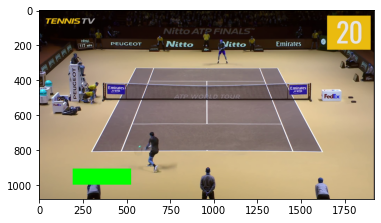

In [5]:
i=random.randint(0,len(keys))
j=str(keys[i])
bbox=list(map(int, data[str(keys[i])]['bbox']))

img=cv2.imread('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames/frame'+str(j)+'.png')
cv2.rectangle(img,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,255,0),-1)
plt.imshow(img)



#Convert bounding box data to MaskRCNN format

In [ ]:
# %%capture cap --no-stderr
# keys1=file_name_selected_train

# print('{')
# for i in range(len(keys1)-1):
#   bbox=list(map(int, data[str(keys1[i])]['bbox']))

#   print('"frame{0}.png":'.format(keys1[i]))
#   print('{{"filename":"frame{}.png","size":122,"regions":['.format(keys1[i]))
#   print('{{"shape_attributes":{{"name":"polygon","all_points_x":{0},"all_points_y":{1}}},"region_attributes":{{"name":"scoreboard"}}}}]}},'.format([bbox[0],bbox[2],bbox[2],bbox[0]],[bbox[1],bbox[1],bbox[3],bbox[3]]))


# i=-1
# bbox=list(map(int, data[str(keys1[i])]['bbox']))

# print('"frame{0}.png":'.format(keys1[i]))
# print('{{"filename":"frame{}.png","size":122,"regions":['.format(keys1[i]))
# print('{{"shape_attributes":{{"name":"polygon","all_points_x":{0},"all_points_y":{1}}},"region_attributes":{{"name":"scoreboard"}}}}]}}'.format([bbox[0],bbox[2],bbox[2],bbox[0]],[bbox[1],bbox[1],bbox[3],bbox[3]]))

# print('}')

# with open('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames/train_via_region_data.json', 'w') as f:
#     f.write(cap.stdout)


# %%capture cap --no-stderr
# keys1=file_name_selected_val

# print('{')
# for i in range(len(keys1)-1):
#   bbox=list(map(int, data[str(keys1[i])]['bbox']))

#   print('"frame{0}.png":'.format(keys1[i]))
#   print('{{"filename":"frame{}.png","size":122,"regions":['.format(keys1[i]))
#   print('{{"shape_attributes":{{"name":"polygon","all_points_x":{0},"all_points_y":{1}}},"region_attributes":{{"name":"scoreboard"}}}}]}},'.format([bbox[0],bbox[2],bbox[2],bbox[0]],[bbox[1],bbox[1],bbox[3],bbox[3]]))


# i=-1
# bbox=list(map(int, data[str(keys1[i])]['bbox']))

# print('"frame{0}.png":'.format(keys1[i]))
# print('{{"filename":"frame{}.png","size":122,"regions":['.format(keys1[i]))
# print('{{"shape_attributes":{{"name":"polygon","all_points_x":{0},"all_points_y":{1}}},"region_attributes":{{"name":"scoreboard"}}}}]}}'.format([bbox[0],bbox[2],bbox[2],bbox[0]],[bbox[1],bbox[1],bbox[3],bbox[3]]))

# print('}')

# with open('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames/val_via_region_data.json', 'w') as f:
#     f.write(cap.stdout)



In [ ]:
%load_ext autoreload
%autoreload 2

In [20]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames")

dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 100
Class Count: 2
  0. BG                                                
  1. scoreboard                                        


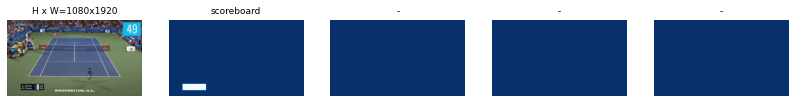

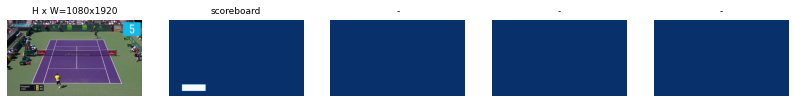

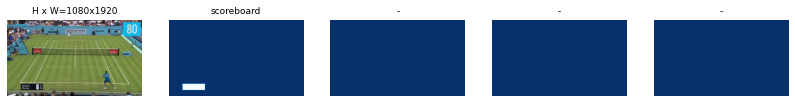

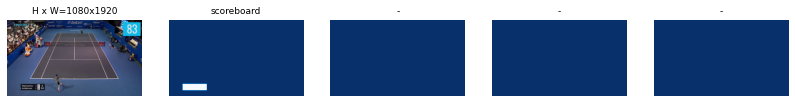

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Start training

In [ ]:
!python /content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/Mask_RCNN/mrcnn/balloon.py train --dataset=/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames  --weights=imagenet

Using TensorFlow backend.
Weights:  imagenet
Dataset:  /content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames
Logs:  /content/drive/MyDrive/sportradar/logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS      

# Inference of trained model

In [ ]:
DEVICE = "/gpu:0"  
TEST_MODE = "inference"


config = balloon.BalloonConfig()
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # DETECTION_MIN_CONFIDENCE = 0.6
    # DETECTION_NMS_THRESHOLD=0.5
config = InferenceConfig()
# config.display()
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)



# Load trained weights

In [ ]:
model.load_weights("/content/drive/MyDrive/sportradar/logs/balloon20211026T1816/mask_rcnn_balloon_0030.h5", by_name=True)        

#Detect Scoreboard

In [13]:
missing=natsorted(list(
    set([i for i in range(int(keys[-1]))])-set(list(map(int,keys)))
    ))

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


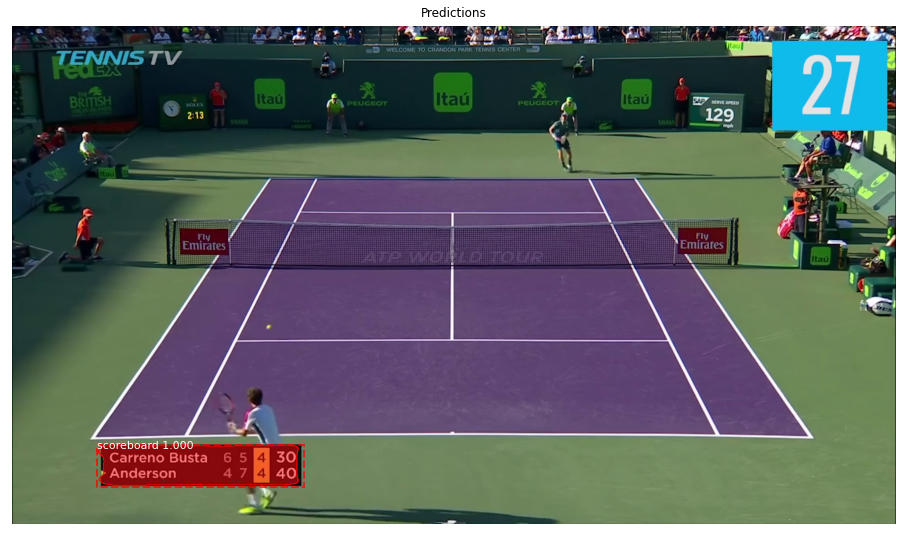

In [21]:
i=random.randint(0,len(keys))
j=str(keys[i])
image=cv2.imread('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames/frame'+j+'.png')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
results = model.detect([image], verbose=1)
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")


#  Extracted ROI

[[907 186 999 636]]


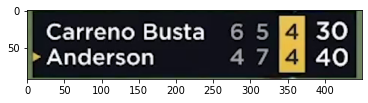

In [24]:
print(r['rois'])
box=r['rois'][0]
res=image[box[0]:box[2],box[1]:box[3]]
plt.imshow(res)

# Try keras_OCR with default weights


> As we can see defaults weights detects some characters but not all of them so lets try fine-tuning the recognizer







Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
Predicted: ['30', 'carreno', 'busta', '65', 'anderson', '7', '40', '4']


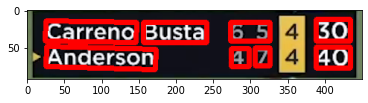

In [25]:
pipeline = keras_ocr.pipeline.Pipeline()

predictions = pipeline.recognize(images=[res])[0]

drawn = keras_ocr.tools.drawBoxes(
    image=res, boxes=predictions, boxes_format='predictions'
)
print(
    # 'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
    'Predicted:', [text for text, box in predictions])
plt.imshow(drawn)

# After converting to required the format we have these .txt files we load for keras_OCR custom training

In [28]:
import csv
train_gt = csv.reader(open("/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/train/train_gt2.txt"))
train_labels=[]
for i in train_gt:
  train_labels.append(i)

for i in range(len(train_labels)):
  train_labels[i][1] =None

val_gt = csv.reader(open("/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/val/val_gt2.txt"))
val_labels=[]
for i in val_gt:
  val_labels.append(i)  

for i in range(len(val_labels)):
  val_labels[i][1] =None


# Image generators for custom OCR training

In [29]:
import imgaug
alphabet = string.digits + string.ascii_letters +'.'+' '+'>'
alphabet = ''.join(sorted(set(alphabet)))

recognizer = keras_ocr.recognition.Recognizer(alphabet=alphabet)

recognizer.compile()
batch_size = 10
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = train_labels,val_labels
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=alphabet,#recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [35]:
print(len(train_labels), len(validation_labels))

464 200


text: > Murray 1 15


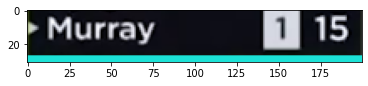

In [33]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)

# Start training (uncomment below)

In [ ]:
# callbacks = [
#     # tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
#     tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_trained/recognizer_atp+spl_trained_14.h5', monitor='val_loss', save_best_only=True),
#     tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_trained/recognizer_borndigital.csv')
# ]
# recognizer.training_model.fit_generator(
#     generator=training_gen,
#     steps_per_epoch=training_steps,
#     validation_steps=validation_steps,
#     validation_data=validation_gen,
#     callbacks=callbacks,
#     epochs=1000
# )

# Load custom trained OCR model

In [37]:
alphabet = string.digits + string.ascii_letters +'.'+' '+'>'
alphabet = ''.join(sorted(set(alphabet)))
recognizer = keras_ocr.recognition.Recognizer(alphabet=alphabet)
recognizer.model.load_weights('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_trained/recognizer_atp+spl_trained_14.h5')


Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


# Create of list of player names as a dictionary reference for error correction

In [45]:
player_names=[]
for i in range(len(keys)):
  player_names.append(data[str(keys[i])]['name_1'])
  player_names.append(data[str(keys[i])]['name_2'])
print(len(list(set(player_names))))  


87


# Run full process of Scoreboard detection + OCR + Name error correction

5025
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Actual:  [193, 908, 551, 995]
Predicted:  [[906 195 994 549]]


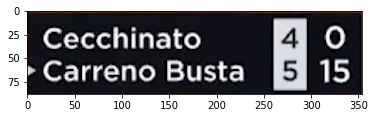

Predicted: Cecchinato 4 0


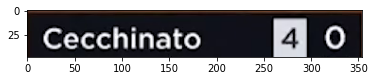

Predicted: > Careno Busta 5 15
Corrected name: Carreno Busta


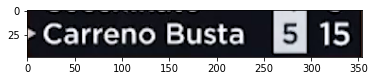

In [44]:

i=random.randint(0,len(keys))
j=str(keys[i])
# j= str(16879)#
print(j)
image=cv2.imread('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames/frame'+j+'.png')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
results = model.detect([image], verbose=1)
r = results[0]

bbox=list(map(int, data[str(keys[i])]['bbox']))
print('Actual: ', bbox)

print('Predicted: ',r['rois'])
box=r['rois'][0]

res=image[box[0]:box[2],box[1]:box[3]]
roi_image=image[box[0]-25:box[2]+25,box[1]-25:box[3]+25]
plt.imshow(res)
plt.show()
player1=res[0:int(res.shape[0]/2)+5,0:int(res.shape[1])]
player2=res[int(res.shape[0]/2)-5:int(res.shape[0]),0:int(res.shape[1])]

words = list(set(player_names))

predicted = recognizer.recognize(image=player1)
print(f'Predicted: {predicted}')
pred_name=re.sub('[^a-zA-Z]+', '', predicted)

corrected_name=difflib.get_close_matches(re.sub('[^a-zA-Z]+', '', predicted), words,n=1)[0]
if(pred_name!=corrected_name):
  print(f'Corrected name: {corrected_name}')


plt.imshow(player1)
plt.show()
predicted = recognizer.recognize(image=player2)
pred_name=re.sub('[^a-zA-Z]+', '', predicted)
print(f'Predicted: {predicted}')
corrected_name=difflib.get_close_matches(re.sub('[^a-zA-Z]+', '', predicted), words,n=1)[0]
if(pred_name!=corrected_name):
  print(f'Corrected name: {corrected_name}')

plt.imshow(player2)
plt.show()


# Player tracking

In [ ]:
from mrcnn import coco
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# config.display()
model_coco = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model_coco.load_weights("/content/drive/MyDrive/savormetrics/mask_rcnn_coco.h5", by_name=True)
class_names = ['BG', 'person','tennis racket', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']



In [ ]:
fin_mask=[]
fin_overlay=[]
for i in range(200):
  image=cv2.imread('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames/frame'+str(i)+'.png')
  results = model_coco.detect([image[150:1000,300:1550]], verbose=1)
  r = results[0]
  fin_mask.append(r['masks'][:,:,1].reshape(850, 1250)+r['masks'][:,:,0].reshape(850, 1250))
  fin_overlay.append(cv2.bitwise_and(image[150:1000,300:1550],image[150:1000,300:1550],mask=fin_mask[i].astype(np.uint8)))


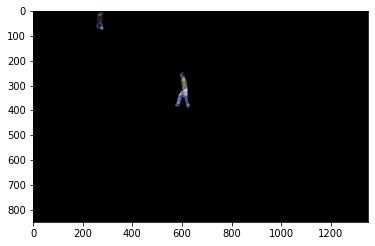

In [ ]:
plt.imshow(fin_overlay[-1])

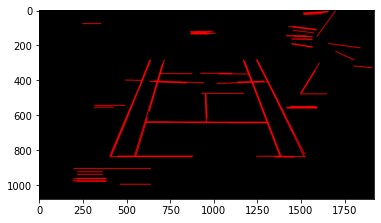

In [46]:
import math
all_lines=[]
i=0
image1=cv2.imread('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames/frame'+str(i)+'.png')
gray=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
kernel_size = 3
# blur_gray = cv2.bilateralFilter(gray,15,10,10)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
low_threshold = 200
high_threshold = 250
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 80  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(image1) * 0  # creating a blank to draw lines on
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
for line in lines:
    for x1,y1,x2,y2 in line:
      cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),3)
plt.imshow(line_image)


In [ ]:
# def solve(bl, tr, p) :
#    if (p[0] > bl[0] and p[0] < tr[0] and p[1] > bl[1] and p[1] < tr[1]) :
#       return True
#    else :
#       return False
# bottom_left = (1, 1)
# top_right = (8, 5)
# point = (5, 4)
# solve(bottom_left,top_right,point)

True

In [ ]:
all_mean=[]
for i in range(len(fin_overlay)):
  mean = cv2.addWeighted(fin_overlay[i],1,line_image[150:1000,300:1550],0.3,1)
  all_mean.append(mean)


In [ ]:
import imageio
imageio.mimsave('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/0_all_mean2.gif', all_mean)

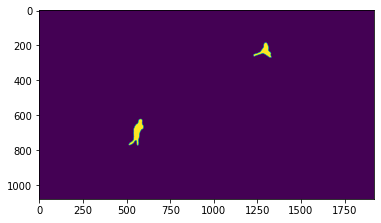

In [ ]:
plt.imshow(r['masks'][:,:,1].reshape(1080, 1920)+r['masks'][:,:,0].reshape(1080, 1920))

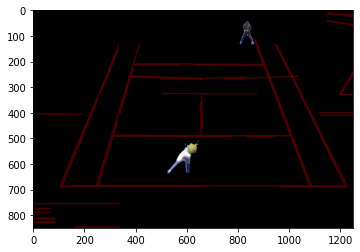

In [ ]:
plt.imshow(all_mean[6])

# End of file (ignore below)

In [51]:
# !pip install pytesseract
# pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'

In [ ]:
import pytesseract
res=cv2.imwrite('tess_test.png',res)
img = cv2.imread('tess_test.png')

# Adding custom options
custom_config = r'--oem 3 --psm 6'
pytesseract.image_to_string(res, config=custom_config)

# Script to convert to keras_OCR format for recognizer fine-tuning

In [ ]:

# %%capture cap --no-stderr
# with open('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/val/val_gt2.txt', 'w') as f:
#     f.write(cap.stdout)


# keys=file_name_selected_val[:]
# # print('[')
# for i in range(len(keys)):
#   img=cv2.imread('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames/frame'+str(keys[i])+'.png')
#   box=list(map(int, data[str(keys[i])]['bbox']))
#   img=img[box[1]:box[3],box[0]:box[2]]
#   img2 = img

#   height, width, channels = img.shape
#   # Number of pieces Horizontally 
#   CROP_W_SIZE  = 1 
#   # Number of pieces Vertically to each Horizontal  
#   CROP_H_SIZE = 2 

#   for ih in range(CROP_H_SIZE ):
#       for iw in range(CROP_W_SIZE ):

#           x = int(width/CROP_W_SIZE * iw)
#           y = int(height/CROP_H_SIZE * ih)
#           h = int((height / CROP_H_SIZE))
#           w = int((width / CROP_W_SIZE ))
#           # print(x,y,h,w)
#           img = img[y:y+h, x:x+w]
#           # print(ih)
          

#           if(data[str(keys[i])]['serving_player']=='name_1'):
            
#             if(ih==0):
#               path="/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/val/" + str(keys[i])+"_0"+  ".png"
#               print("{2},None,> {0} {1}".format(data[str(keys[i])]['name_1'],data[str(keys[i])]['score_1'].replace('-',' '),path))
#               cv2.imwrite(path,img)
#             else:
#               path="/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/val/" + str(keys[i])+"_1"+  ".png"
#               print("{2},None,{0} {1}".format(data[str(keys[i])]['name_2'],data[str(keys[i])]['score_2'].replace('-',' '),path))
#               cv2.imwrite(path,img)
#           else:
            
#             if(ih==0):
#               path="/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/val/" + str(keys[i])+"_0"+  ".png"
#               print("{2},None,{0} {1}".format(data[str(keys[i])]['name_1'],data[str(keys[i])]['score_1'].replace('-',' '),path))
#               cv2.imwrite(path,img)
#             else:
#               path="/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/val/" + str(keys[i])+"_1"+  ".png"
#               print("{2},None,> {0} {1}".format(data[str(keys[i])]['name_2'],data[str(keys[i])]['score_2'].replace('-',' '),path))
#               cv2.imwrite(path,img)




          
#           img = img2
#   # break
# # print(']')  



# %%capture cap --no-stderr
# with open('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/train/train_gt2.txt', 'w') as f:
#     f.write(cap.stdout)


# keys=file_name_selected_train[:]
# # print('[')
# for i in range(len(keys)):
#   img=cv2.imread('/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/data/frames/frame'+str(keys[i])+'.png')
#   box=list(map(int, data[str(keys[i])]['bbox']))
#   img=img[box[1]:box[3],box[0]:box[2]]
#   img2 = img

#   height, width, channels = img.shape
#   # Number of pieces Horizontally 
#   CROP_W_SIZE  = 1 
#   # Number of pieces Vertically to each Horizontal  
#   CROP_H_SIZE = 2 

#   for ih in range(CROP_H_SIZE ):
#       for iw in range(CROP_W_SIZE ):

#           x = int(width/CROP_W_SIZE * iw)
#           y = int(height/CROP_H_SIZE * ih)
#           h = int((height / CROP_H_SIZE))
#           w = int((width / CROP_W_SIZE ))
#           # print(x,y,h,w)
#           img = img[y:y+h, x:x+w]
#           # print(ih)
          

#           if(data[str(keys[i])]['serving_player']=='name_1'):
            
#             if(ih==0):
#               path="/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/train/" + str(keys[i])+"_0"+  ".png"
#               print("{2},None,> {0} {1}".format(data[str(keys[i])]['name_1'],data[str(keys[i])]['score_1'].replace('-',' '),path))
#               cv2.imwrite(path,img)
#             else:
#               path="/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/train/" + str(keys[i])+"_1"+  ".png"
#               print("{2},None,{0} {1}".format(data[str(keys[i])]['name_2'],data[str(keys[i])]['score_2'].replace('-',' '),path))
#               cv2.imwrite(path,img)
#           else:
            
#             if(ih==0):
#               path="/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/train/" + str(keys[i])+"_0"+  ".png"
#               print("{2},None,{0} {1}".format(data[str(keys[i])]['name_1'],data[str(keys[i])]['score_1'].replace('-',' '),path))
#               cv2.imwrite(path,img)
#             else:
#               path="/content/drive/MyDrive/sportradar/CV-interview-scoreboard-task-material/ocr_data/train/" + str(keys[i])+"_1"+  ".png"
#               print("{2},None,> {0} {1}".format(data[str(keys[i])]['name_2'],data[str(keys[i])]['score_2'].replace('-',' '),path))
#               cv2.imwrite(path,img)




          
#           img = img2
#   # break
# # print(']')  




